# CT5135 Assignment-2 
## Using Residual connected CNN for Classification
### Importing Libraries

In [1]:
!pip install -q wandb
import numpy as np
import pandas as pd 
from sklearn import metrics 
from glob import glob 
from tqdm import tqdm 

import matplotlib.pyplot as plt
import seaborn as sns

import timm
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim 
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

from PIL import Image
import wandb


### Setting up Weights and Biases
Weights and biases can serve as a tool to track the experiments done on any platform and framework. It offers a way to generate reports based on real time statistics based on the model runs

In [2]:
wandb.login(key='############') #Masked the key 

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
wandb.init(
    project="road-surface-cnn",
    config={
    "learning_rate": 0.02,
    "architecture":"Residual CNN",
    "dataset":"Road Surface Dataset",
    "epochs":20,
    }
)

wandb: Currently logged in as: hemanthh17. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240331_011323-lgrfvmv7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dainty-silence-2
wandb: ⭐️ View project at https://wandb.ai/hemanthh17/road-surface-cnn
wandb: 🚀 View run at https://wandb.ai/hemanthh17/road-surface-cnn/runs/lgrfvmv7


### Setting up configuration for the Experiment

In [4]:
class CFG:
    train_batch_size=32
    batch_size=32
    loss_fn=nn.CrossEntropyLoss()
    epochs=20
    stats=False
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ',CFG.device)

Device:  cuda


## Finding Channel Mean and Standard Deviation

If the CFG.stats is set true then the channel mean, and standard deviation is computed which can help in normalizing the image data.
The sampling step is done in order to procure a subset for the training of the neural network. This was done due to computation and space constraints. An alternate equivalent approach is to perform K fold cross validation and choose some of the folds for the training. 

In [5]:
train_data_path='/kaggle/input/road-surface-dataset/Group_6_water_smooth/train'
transform= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
###Sampling the training data
train_dataset_full=datasets.ImageFolder(train_data_path,transform=transform)
#Finding the class counts
class_counts=np.bincount(train_dataset_full.targets)
#FIniding the minimum class count present
min_samples_per_class=min(class_counts)
#Finding the number of data points to take from the classes
num_samples_per_class=min(min_samples_per_class,14500//len(train_dataset_full.classes))
#Finding number of samples to be considered
total_num_samples=num_samples_per_class*len(train_dataset_full.classes)
balanced_indices=[]
for idx in range(len(train_dataset_full.classes)):
    class_indices=np.where(np.array(train_dataset_full.targets)==idx)[0]
    sampled_indices=np.random.choice(class_indices,num_samples_per_class,replace=False)
    balanced_indices.extend(sampled_indices)
#Creating Subset of Data
train_dataset=torch.utils.data.Subset(train_dataset_full, balanced_indices[:total_num_samples])
if CFG.stats:
    stat_train_images=[image for image,label in train_dataset]  
    stat_train_stack=torch.stack(stat_train_images,dim=1).permute(1,0,2,3)
    print("Mean: ",torch.mean(stat_train_stack,dim=(0,2,3)))
    print("Standard Deviation: ",torch.std(stat_train_stack,dim=(0,2,3)))



### Setting the Image transform to be considered 

Here in the Image transform the images are resized to 224x224 size. This data is then converted to a tensor which can now be passed into the model. Post the conversion to tensor with the help of precomputed channel mean and standard deviation, the image data is normalised.

In [6]:
image_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4855, 0.4906, 0.4701),(0.1437, 0.1478, 0.1576)) #Mean and Standard Deviation calculated from setting CFG.stats=True
])
train_dataset.dataset.transform=image_transform

### Creating the Torch Datasets

Torch datasets are necessary in order to pass the data into the model. The data is maintained here depnding on the batch size specified. It is an efficient in both computation and memory.

In [7]:
val_data_path='/kaggle/input/road-surface-dataset/Group_6_water_smooth/valid'
test_data_path='/kaggle/input/road-surface-dataset/Group_6_water_smooth/test'
val_dataset=datasets.ImageFolder(val_data_path,transform=image_transform)
test_dataset=datasets.ImageFolder(test_data_path,transform=image_transform)

In [8]:
train_loader=DataLoader(train_dataset,batch_size=CFG.train_batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=CFG.batch_size,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=CFG.batch_size,shuffle=False)

### Creating the Model 

A custom CNN model with residual connections is created with the torch.nn module. Residual connections in CNN were not implemented for this task in earlier works. Here the Residual block and the CNN block are created separately and this helps to easily modify the architecture depending on the complexity.
The residual block checks internally if the dimensions match to perform the addition operation else a separate network is used to procure the data that can be used by the residual network.

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1):
        super(ResidualBlock,self).__init__()
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2=nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU(inplace=True)
        self.stride=stride
        if stride!=1 or in_channels!=out_channels:
            self.residual=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.residual=nn.Identity()

    def forward(self,x):
        identity=self.residual(x)
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        out=self.conv2(out)
        out=self.bn2(out)
        out+=identity
        out=self.relu(out)
        return out

class ConvResNet(nn.Module):
    def __init__(self,in_channels,num_classes):
        super(ConvResNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels,64,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU(inplace=True)
        self.residual1=ResidualBlock(64,64)
        self.conv2=nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1,bias=False)
        self.bn2=nn.BatchNorm2d(128)
        self.residual2=ResidualBlock(128,128)
        self.conv3=nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1,bias=False)
        self.bn3=nn.BatchNorm2d(256)
        self.residual3=ResidualBlock(256,256)
        self.avg_pool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(256,num_classes)

    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.residual1(x)
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu(x)
        x=self.residual2(x)
        x=self.conv3(x)
        x=self.bn3(x)
        x=self.relu(x)
        x=self.residual3(x)
        x=self.avg_pool(x)
        x=torch.flatten(x, 1)
        x=self.fc(x)
        return x



### Training Loop

Here the training loop trains on the training data, and validates the model on the validation dataset. It uses the Adam as the optimizer. The loss function used is the Cross Entropy Loss which is effective in classification tasks. GPU is used from Kaggle in order to train the model and save the weights. The learning curves and the accuracy curves are plotted to help evaluate the performance.

100%|██████████| 454/454 [05:39<00:00,  1.34it/s]


Epoch 1/20, Train Loss:0.7190298624544836, Train accuracy:0.6847368784054073
Validation Loss: 0.6409365913247674, Validation Accuracy: 0.7252032520325203


100%|██████████| 454/454 [04:55<00:00,  1.54it/s]


Epoch 2/20, Train Loss:0.6715812375976493, Train accuracy:0.7153134029129076
Validation Loss: 0.5938871085643769, Validation Accuracy: 0.7516260162601626


100%|██████████| 454/454 [04:55<00:00,  1.54it/s]


Epoch 3/20, Train Loss:0.5882750063758446, Train accuracy:0.7567663187687953
Validation Loss: 0.5296127993643769, Validation Accuracy: 0.7898373983739837


100%|██████████| 454/454 [04:53<00:00,  1.55it/s]


Epoch 4/20, Train Loss:0.5446216857367955, Train accuracy:0.7847160799575447
Validation Loss: 0.5252381954251266, Validation Accuracy: 0.7910569105691057


100%|██████████| 454/454 [04:52<00:00,  1.55it/s]


Epoch 5/20, Train Loss:0.4971826029827746, Train accuracy:0.7995754466654873
Validation Loss: 0.490500523162082, Validation Accuracy: 0.8008130081300813


100%|██████████| 454/454 [04:52<00:00,  1.55it/s]


Epoch 6/20, Train Loss:0.4641094787695201, Train accuracy:0.8128427383690076
Validation Loss: 0.472980503192762, Validation Accuracy: 0.8097560975609757


100%|██████████| 454/454 [04:51<00:00,  1.56it/s]


Epoch 7/20, Train Loss:0.45001936059272224, Train accuracy:0.8203313874638835
Validation Loss: 0.40501551279207554, Validation Accuracy: 0.8398373983739837


100%|██████████| 454/454 [04:51<00:00,  1.56it/s]


Epoch 8/20, Train Loss:0.41496382888345623, Train accuracy:0.8377262810307211
Validation Loss: 0.38801207065097687, Validation Accuracy: 0.8565040650406504


100%|██████████| 454/454 [04:51<00:00,  1.56it/s]


Epoch 9/20, Train Loss:0.39907589059622917, Train accuracy:0.8445073412347426
Validation Loss: 0.3938940366593803, Validation Accuracy: 0.8544715447154472


100%|██████████| 454/454 [04:51<00:00,  1.56it/s]


Epoch 10/20, Train Loss:0.3759464266481248, Train accuracy:0.8529984079249956
Validation Loss: 0.4192762215689915, Validation Accuracy: 0.8394308943089431


100%|██████████| 454/454 [04:51<00:00,  1.56it/s]


Epoch 11/20, Train Loss:0.37074691460306197, Train accuracy:0.8528804764431865
Validation Loss: 0.4660555312303993, Validation Accuracy: 0.8077235772357724


100%|██████████| 454/454 [04:51<00:00,  1.56it/s]


Epoch 12/20, Train Loss:0.3363504238579304, Train accuracy:0.8601332625744442
Validation Loss: 0.38288571856370784, Validation Accuracy: 0.8491869918699188


100%|██████████| 454/454 [04:50<00:00,  1.56it/s]


Epoch 13/20, Train Loss:0.33158374146573566, Train accuracy:0.8700395070464061
Validation Loss: 0.35391130140884136, Validation Accuracy: 0.8585365853658536


100%|██████████| 454/454 [04:51<00:00,  1.56it/s]


Epoch 14/20, Train Loss:0.30744762440982937, Train accuracy:0.8787074709593726
Validation Loss: 0.3581474523839912, Validation Accuracy: 0.8617886178861789


100%|██████████| 454/454 [04:50<00:00,  1.56it/s]


Epoch 15/20, Train Loss:0.3050639631871692, Train accuracy:0.8779409163276136
Validation Loss: 0.38247448522143246, Validation Accuracy: 0.8402439024390244


100%|██████████| 454/454 [04:50<00:00,  1.56it/s]


Epoch 16/20, Train Loss:0.287392667303234, Train accuracy:0.8821274839318356
Validation Loss: 0.34823383440801164, Validation Accuracy: 0.8768292682926829


100%|██████████| 454/454 [04:51<00:00,  1.56it/s]


Epoch 17/20, Train Loss:0.25663119308376603, Train accuracy:0.8978713367533463
Validation Loss: 0.2939985069499268, Validation Accuracy: 0.8947154471544716


100%|██████████| 454/454 [04:52<00:00,  1.55it/s]


Epoch 18/20, Train Loss:0.24543980363566545, Train accuracy:0.9059496432572676
Validation Loss: 0.2815855007043214, Validation Accuracy: 0.9036585365853659


100%|██████████| 454/454 [04:50<00:00,  1.56it/s]


Epoch 19/20, Train Loss:0.23584059836704308, Train accuracy:0.9086031015979715
Validation Loss: 0.2861538423149566, Validation Accuracy: 0.8959349593495934


100%|██████████| 454/454 [04:50<00:00,  1.56it/s]


Epoch 20/20, Train Loss:0.2322113697294844, Train accuracy:0.9095465534524442
Validation Loss: 0.3571745305708269, Validation Accuracy: 0.8735772357723577


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
wandb: train_accuracy: ▁▂▃▄▅▅▅▆▆▆▆▆▇▇▇▇████
wandb:      train_loss █▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
wandb:   val_accuracy: ▁▂▄▄▄▄▅▆▆▅▄▆▆▆▆▇███▇
wandb:        val_loss █▇▆▆▅▅▃▃▃▄▅▃▂▂▃▂▁▁▁▂
wandb: 
wandb: Run summary:
wandb:           epoch 20
wandb: train_accuracy: 0.90955
wandb:      train_loss 0.23221
wandb:   val_accuracy: 0.87358
wandb:        val_loss 0.35717
wandb: 
wandb: 🚀 View run dainty-silence-2 at: https://wandb.ai/hemanthh17/road-surface-cnn/runs/lgrfvmv7
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240331_011323-lgrfvmv7/logs


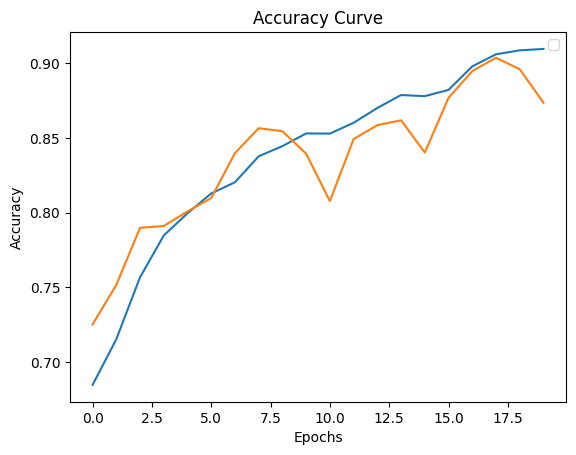

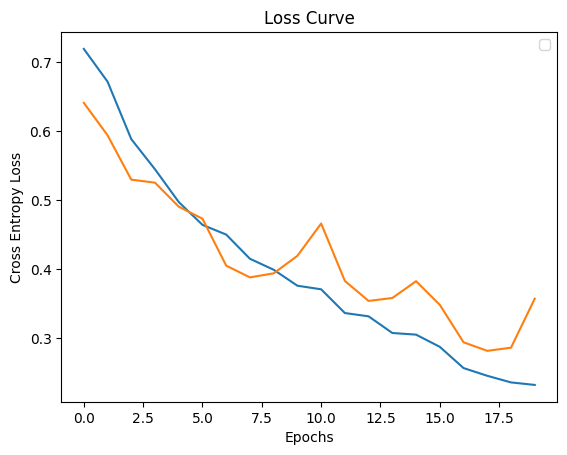

In [10]:
device=CFG.device
model=ConvResNet(3,3).to(device)
optimizer=optim.RAdam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss().to(device)
def train_fn(model,train_loader,criterion,optimizer,num_epochs):
    train_losses=[]
    val_losses=[]
    train_accs=[]
    val_accs=[]
    train_loss=0.0
    correct=0
    total=0
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images,labels in tqdm(train_loader):
            images,labels=images.to(device),labels.to(device) 
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()*images.size(0)
            _,predicted=torch.max(outputs,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
        epoch_loss=running_loss/len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_acc=correct/total
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss:{epoch_loss}, Train accuracy:{train_acc}")
        wandb.log({'train_loss':epoch_loss,'epoch':epoch+1,'train_accuracy:':train_acc})
        model.eval()
        val_loss=0.0
        correct=0
        total=0
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels=images.to(device),labels.to(device) 
                outputs=model(images)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()*images.size(0)
                _,predicted=torch.max(outputs,1)
                total+=labels.size(0)
                correct+=(predicted==labels).sum().item()
        val_loss/=len(val_loader.dataset)
        val_losses.append(val_loss)
        val_acc=correct/total
        val_accs.append(val_acc)
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")
        wandb.log({'val_loss':val_loss,'val_accuracy:':val_acc})
    plt.figure()
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.figure()
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Loss Curve')
    plt.legend()
train_fn(model,train_loader,criterion,optimizer,CFG.epochs)
wandb.finish()

### Testing Loop

The model predicts the test data and the performace is shown as the overall accuracy and F1 score achieved. Accuracy cannot be openly taken as the data label distribution is imbalanced. 

In [11]:
model.eval()
test_loss=0.0
correct=0
total=0
predictions=[]
targets_list=[]
with torch.no_grad():
    for images,labels in tqdm(test_loader):
        images, labels=images.to(device), labels.to(device) 
        outputs=model(images)
        loss=criterion(outputs, labels)
        test_loss+=loss.item()*images.size(0)
        _,predicted=torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        targets_list.extend(labels.cpu().numpy())
        total+=labels.size(0)
        correct+=(predicted == labels).sum().item()
test_loss/=len(test_loader.dataset)
test_acc=correct/total
f1=metrics.f1_score(targets_list, predictions, average='macro')
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, F1 Score: {f1}")



100%|██████████| 94/94 [00:46<00:00,  2.04it/s]

Test Loss: 0.16635075225884288, Test Accuracy: 0.9425596237823312, F1 Score: 0.6493936454361906


### Confusion Matrix
Confusion Matrix can help us further analyse the trend of prediction in the test dataset. From the result we can see class 0 (Water Asphalt Smooth) performs bad when compared to other classes. 

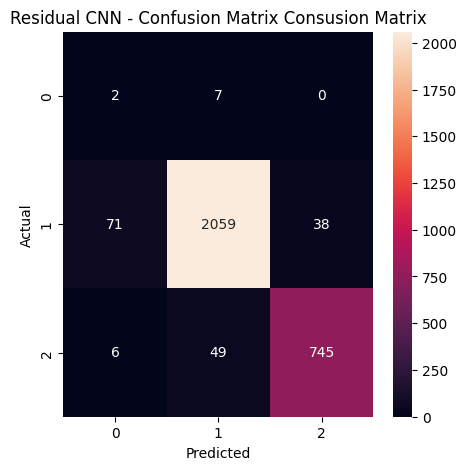

In [12]:
def conf_matrix_plotter(ytest,ypred,figname):
    confusion= metrics.confusion_matrix(ytest,ypred)
    plt.figure(figsize=(5,5))
    sns.heatmap(confusion,annot=True,fmt='d')
    plt.title(f"{figname} Consusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel("Actual")
    plt.show()
conf_matrix_plotter(targets_list,predictions,'Residual CNN - Confusion Matrix')

### Saving the model 

The models state dictionary is saved which can be loaded at any point in order to be used for any web interface.

In [13]:
torch.save(model.state_dict(),'residual-model-final.pth')